#Assignment 1: Model Predictive Control of a N-link Manipulator

Please refer to the [assignment writeup](https://docs.google.com/document/d/1y5oDHOqfGS6U5HnidasQphaJHBPTT9vaIc_-dNfdcxw/edit?usp=sharing)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import rc
from IPython.display import HTML, Image
import torch
from torch.autograd.functional import jacobian, hessian
rc('animation', html='jshtml')

c:\Users\ortha\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Arm kinematics and visualization

When you build a robot arm, the first thing you want to do is to write down all the numbers you need to describe it. For our planar N-link arm, it boils down to 4 numbers:
* How many links does the arm have?
* How long is each link?
* What is the mass of each link?
* Where is the base of the arm located in the world?

We have provided some reasonable numbers, but feel free to experiment with different parameters.

In [2]:
# Parameters of the arm
num_links = 2
length_m = 0.5 * np.ones(num_links)
mass_kg = 1 * np.ones(num_links) #  Assume that the mass of the link is concentrated at the end of the link.
base_se2 = np.array([0.0, 0.0, 0.0]) # Base of the arm in world frame

Let’s visualize the arm in different configurations. the arm when in different *configurations*. The *configuration* of the arm is specified by a vector of joint angles.
Given these joint angles, one can proceed link by link and compute the position of the link in the world. This computation is referred to as the [forward kinematics](https://en.wikipedia.org/wiki/Forward_kinematics). Once we have the link positions, we can visualize the arm easily.

We have provided some code for both forward kinematics and arm visualization. Try visualizing different configurations so you get some intuition about forward kinematics!

[[0.16234446]
 [2.92894899]]


C:\Users\ortha\AppData\Local\Temp\ipykernel_29768\4112566137.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  world_link = world_link @ Tmatrix(np.array([0, 0, theta[idx]]))
C:\Users\ortha\AppData\Local\Temp\ipykernel_29768\4112566137.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Tmatrix = lambda se2:  np.array([(np.cos(se2[2]), -np.sin(se2[2]), se2[0]),
C:\Users\ortha\AppData\Local\Temp\ipykernel_29768\4112566137.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so can

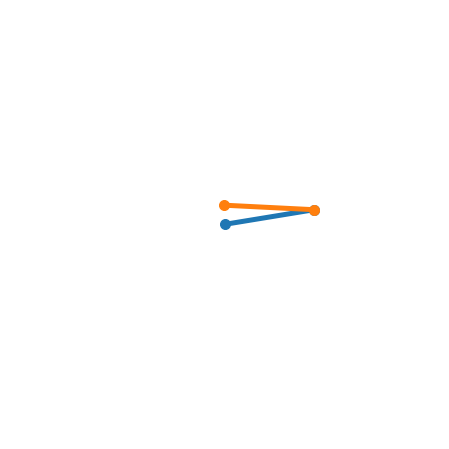

In [3]:
def forward_kinematics(theta, length_m, base_se2):
    """ Compute the location of each link in the arm given joint angles
    Args:
        theta: (N,1) array of joint angles
        length_m: (N,1) array of arm lengths
        base_se2: (3,1) array of base frame (x,y,theta)
    Returns:
        [N+1,2] array of x,y location of each link
    """
    Tmatrix = lambda se2:  np.array([(np.cos(se2[2]), -np.sin(se2[2]), se2[0]),
                                (np.sin(se2[2]), np.cos(se2[2]), se2[1]),
                                (0., 0., 1.)])
    num_links = theta.shape[0]
    world_link = Tmatrix(base_se2)

    link_pos = world_link[0:2,-1]
    for idx in range(0, num_links):
        # First rotate
        world_link = world_link @ Tmatrix(np.array([0, 0, theta[idx]]))
        # Then traslate
        world_link = world_link @ Tmatrix(np.array([length_m[idx], 0, 0]))
        link_pos = np.vstack((link_pos, world_link[0:2,-1] ))
    return link_pos

def plot_arm(theta, length_m, base_se2):
    """ Plots arm given joint angles
    Args:
        theta: (N,1) array of joint angles
        length_m: (N,1) array of arm lengths
        base_se2: (3,1) array of base frame (x,y,theta)
    """
    print(theta)
    link_pos = forward_kinematics(theta, length_m, base_se2)
    for idx in range(1, link_pos.shape[0]):
        plt.plot(link_pos[idx-1:idx+1,0], link_pos[idx-1:idx+1,1], '-o', linewidth=5, markersize=10)


# Let's try visualizing some arm configurations
fig = plt.figure(figsize=(8, 8))
plt.xlim([-1.2, 1.2])
plt.ylim([-1.2, 1.2])
plt.axis('off')
plt.grid()
plt.gca().set_aspect('equal', adjustable='box')

theta = np.random.randn(num_links, 1)
plot_arm(theta, length_m, base_se2)
fig.show()

Now let's animate the arm. This will come in handy when we develop controllers that optimize the motion of the arm. We can also optionally stick a marker to the end-effector to see a trace of the arm.

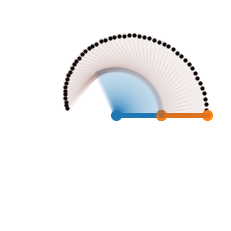

In [4]:
def animate_arm(x_traj, draw_ee=False, draw_trace=False):
    """ Animate the arm as it follows a joint angle trajectory
    Args:
        theta_traj: List of (N,1) joint angles
        draw_ee: If true, plot a trace of the end effector as it moves
    Returns:
        animate object
    """
    fig = plt.figure()
    plt.xlim([-1.2, 1.2])
    plt.ylim([-1.2, 1.2])
    plt.axis('off')
    plt.grid()
    plt.gca().set_aspect('equal', adjustable='box')

    arm_lines = []
    for idx in range(0, length_m.shape[0]):
        arm_lines += plt.plot([0, 0], [0, 0], '-o', linewidth=5, markersize=10)

    def update_arm(i):
        theta = x_traj[i][:2]
        link_pos = forward_kinematics(theta, length_m, base_se2)
        if draw_ee:
            plt.scatter(link_pos[-1,0], link_pos[-1,1], s=10, color='k')
        if draw_trace:
            colors = plt.cm.tab10(np.linspace(0,1,link_pos.shape[0]))
            for idx in range(1, link_pos.shape[0]):
                plt.plot(link_pos[idx-1:idx+1,0], link_pos[idx-1:idx+1,1], linewidth=5, alpha=0.1, color=colors[idx-1])
        for idx in range(1, link_pos.shape[0]):
            arm_lines[idx-1].set_data(link_pos[idx-1:idx+1,0], link_pos[idx-1:idx+1,1])

    anim = FuncAnimation(fig, update_arm, frames=len(x_traj), interval=30, blit=False, repeat=False)
    return anim

# Let's animate the arm moving from an initial to a final configuration
x_0 = np.array([0., 0., 0., 0.])
x_f = np.array([2., 2., 0., 0.])
theta_traj = list(np.linspace(x_0, x_f, num=50, endpoint=True))
animate_arm(theta_traj, draw_ee=True, draw_trace=True)

# Deriving Dynamics of a 2-link Manipulator

Let’s begin by modeling our N-link manipulator. We will stick to N=2 to keep things simple (more on N>2 later).

Derive the dynamics of a N=2 link arm. The dynamics model is a function that takes the current state, current set of control torques and returns the next state. An elegant way to derive the dynamics is to write down the Euler Lagrange equations, as shown in [Lynch & Park, Pg 273.](http://hades.mech.northwestern.edu/images/7/7f/MR.pdf)

In [5]:
def manipulator_dynamics(x, u, dt=0.1):
    """ Compute the dynamics of a manipulator
    Args:
        x: (2N,1) array of arm state (joint angle, joint velocity)
        u: (N,1) array of joint torques
        dt: discrete time interval
    Returns:
        The next state
    Hint: Make sure this function mantains the gradient to the inputs
    """
    joint_angle, joint_vel = torch.split(x, 2)
    
    
    # get mass and length
    mass_list = torch.tensor(mass_kg)
    length_list = torch.tensor(length_m)
    

    # \tau_i = ml^2 \ddot{\theta}_i
    joint_accel = u / (mass_list * (length_list ** 2)) 

    
    next_x_angle = joint_angle + dt * joint_vel + dt ** 2 * joint_accel / 2 
    next_x_vel = joint_vel + dt * joint_accel
    
    next_x = torch.cat((next_x_angle, next_x_vel), 0)

    return next_x

#x = torch.tensor([12, 222, 300, 12])
#u = torch.tensor([1, 2])
#print(manipulator_dynamics(x, u))

# The Linear Quadratic Regulator (LQR)

It’s now time to code up your first decision making algorithm – LQR or value-iteration-for-linear-dynamics-and-quadratic-costs! Let’s regulate the arm around the rest position Θ = (0,0).

A core component of LQR is linearizing dynamics and quadracizing the cost about some reference point. Instead of doing this by hand, you can use the [jacobian](https://pytorch.org/docs/stable/generated/torch.autograd.functional.jacobian.html) and [hessian](https://pytorch.org/docs/stable/generated/torch.autograd.functional.hessian.html) functions provided by PyTorch.  

In [6]:
def regulator_cost(x, u, theta_ref):
    """ Computes quadratic cost of state, action pair
    Args:
        x: Current state
        u: Current control action
        theta_ref: The reference angle to regulate the arm around
    Returns:
        Scalar cost
    """
    theta, theta_dot = torch.split(x, 2)
    delta_angle = torch.sum(torch.pow(theta - theta_ref, 2))
    delta_vel = torch.sum(torch.pow(theta_dot, 2))
    delta_u = torch.sum(torch.pow(u, 2))

    return delta_angle + delta_vel #+ delta_u

def lqr_input_matrices(x_ref, u_ref, dynamics_fun, cost_fun):
    """ Compute A, B, Q, R matrices
    Args:
        x_ref: State around which to linearize
        u_ref: Action around which to linearize
        dynamics_fun: Dynamics function that takes in x_{t}, u_{t} and returns x_{t+1}
        cost_fun: Cost function that takes in x_{t}, u_{t} and returns a scalar value
    Returns:
        A, B, Q, R matrices
    Hint: Use the jacobian and hessians of the dynamics function and cost function respecitively
    """

    A_input = lambda x: dynamics_fun(x, u_ref)
    B_input = lambda u: dynamics_fun(x_ref, u)
    QR_input = lambda input: cost_fun(input[:len(x_ref)], input[len(x_ref):])

    A = torch.autograd.functional.jacobian(A_input, x_ref)
    B = torch.autograd.functional.jacobian(B_input, u_ref)
    QR = torch.autograd.functional.hessian(QR_input, torch.cat((x_ref, u_ref), 0))
    Q = QR[:len(x_ref), :len(x_ref)] / 2
    R = QR[len(x_ref):, len(x_ref):] / 2

    return A, B, Q, R
#lqr_input_matrices(x_ref, u_ref, dynamics_fun, cost_fun)

def lqr_gains(A, B, Q, R, H):
    """ Run value iteration and compute V and K matrices for each time step
    Args:
        A: (2N, 2N) dynamics matrix
        B: (2N, N) dynamics matrix
        Q: (2N, 2N) quadratic cost matrix
        R: (N, N) quadratic cost matrix
        H: Time horizon
    Returns:
        List of K matrices for each timestep
    """
    K_matrices = torch.empty(H, 2, 4)
    V_t = Q 
    K_matrices[H-1] = torch.zeros_like(B.T) # B.T has the correct shape of N x 2N
    for t in range(H-2, -1, -1):

        K_prior = - (torch.linalg.inv(R + B.T @ V_t @ B)) @ B.T @ V_t @ A 
        K_matrices[t] = K_prior

        V_t_prior = Q + (K_prior.T @ R @ K_prior) + ((A + B @ K_prior).T @ V_t @ (A + B @ K_prior))

        V_t = V_t_prior

    return K_matrices

    
def lqr_forward(x_0, x_ref, K_list, dynamics_fun):
    """  Start from initial state and iteratively apply K matrices and dynamics
    to roll out a trajectory
    Args:
        x_0: (2N, 1) initial state
        K_list: List of K matrices for each timestep
        dynamics_fun: The dynamics function
    Returns:
        List of states, actions one for each timestep
    """
    x_final = x_ref 

    x_traj = []
    u_traj = []

    x_ref = x_0
    u_ref = K_list[0] @ x_ref

    x_traj.append(x_ref)
    u_traj.append(u_ref)
    
    for i in range(1, len(K_list)):
        x_ref = dynamics_fun(x_ref, u_ref)
        
        u_ref = K_list[i] @ (x_ref - x_final).float()
        x_traj.append(x_ref)
        u_traj.append(u_ref)

    return x_traj, u_traj

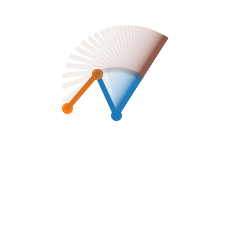

In [7]:
# Apply LQR to regulate the arm starting from an initial state
x_0 = torch.tensor([2.0, 2.0, 0., 0.]) # Initial state
x_ref = torch.tensor([1., 0., 0., 0.], requires_grad=True) # State that we are regulating around
#x_ref = torch.tensor([0.5, 0.5, 0., 0.], requires_grad=True) # State that we are regulating around
u_ref = torch.tensor([0., 0.], requires_grad=True)
H = 100 # Horizon

dynamics_fun = lambda x, u: manipulator_dynamics(x, u)
cost_fun = lambda x, u: regulator_cost(x, u, x_ref[0:2])

A, B, Q, R = lqr_input_matrices(x_ref, u_ref, dynamics_fun, cost_fun)
K_list = lqr_gains(A, B, Q, R, H)

x_traj, u_traj = lqr_forward(x_0,x_ref,K_list, manipulator_dynamics)

x_traj = [x.detach() for x in x_traj]
animate_arm(x_traj, draw_trace=True)

(array([-2.,  0.,  2.,  4.,  6.,  8., 10., 12., 14.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

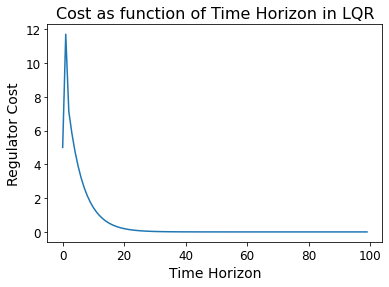

In [8]:
time_horizon = np.arange(len(x_traj))
u_traj = [u.detach() for u in u_traj]
cost_arr = []
for i in range(len(x_traj)):
    cost_arr.append(regulator_cost(x_traj[i], u_traj[i], x_ref[0:2]).detach().numpy())
plt.plot(time_horizon, cost_arr)
plt.title('Cost as function of Time Horizon in LQR', fontsize=16)  # Title
plt.xlabel('Time Horizon', fontsize=14)       # X-axis label
plt.ylabel('Regulator Cost', fontsize=14)       # Y-axis label
plt.xticks(fontsize=12)                 # X-axis tick labels
plt.yticks(fontsize=12)  

# Iterative Linear Quadratic Regulator (iLQR)

We are now going to use iLQR to move the end-effector of the arm to a target position. The key change from the previous LQR problem is that the cost function now looks at the end effector coordinates of the arm, i.e. (ee(t) - ee_goal)^2 where ee(t) is the end effector position.

We recommend the following key steps:

1. **Time-varying LQR:** Update LQR to handle time varying At, Bt, Qt, Rt matrices
2. **Affine LQR:** Since we are linearizing about (xref, uref) and not the origin, we need to account for offset terms in the dynamics. This is best handled by going to homogeneous coordinates where we augment the state x= [x 1].
3. **Change of basis:** Since we have a trajectory  (xref(t), uref(t)) that we are linearizing about, it’s best to change coordinates to work as an offset from (xref(t), uref(t))

In [9]:
# Code for iLQR

def end_effector_cost(x, u, ee_goal):
    """ Computes cost of state, action pair
    Args:
        x: Current state
        u: Current control action
        ee_goal: The goal
        theta_ref: The reference angle to regulate the arm around
    Returns:
        Scalar cost
    """
    theta, theta_dot = torch.split(x, 2)
    delta_angle = torch.sum(torch.pow(theta - ee_goal, 2))
    delta_vel = torch.sum(torch.pow(theta_dot, 2))
    delta_u = torch.sum(torch.pow(u, 2))

    return delta_angle + delta_vel + delta_u

def time_varying_lqr_matrices(x_traj, u_traj, dynamics_fun, cost_fun):
    """ Compute A, B, Q, R matrices
    Args:
        x_traj: States around which to linearize
        u_traj: Actions around which to linearize
        dynamics_fun: Dynamics function that takes in x_{t}, u_{t} and returns x_{t+1}
        cost_fun: Cost function that takes in x_{t}, u_{t} and returns a scalar value
    Returns:
        A_t, B_t, Q_t, R_t matrices
    """
    A_arr = []
    B_arr = []
    Q_arr = []
    R_arr = []
    for x_ref, u_ref in zip(x_traj, u_traj):

        A, B, Q, R = lqr_input_matrices(x_ref, u_ref, dynamics_fun, cost_fun)
        A_arr.append(A)
        B_arr.append(B)
        Q_arr.append(Q)
        R_arr.append(R)
    
    return A_arr, B_arr, Q_arr, R_arr

def affine_projection(x_traj, x_off, A_t, B_t, Q_t, u_traj, cost_fun):
    """ Compute A, B, Q, R matrices
    Args:
        x_traj: States of trajectory 
        x_off: States of offset at each time step
        A_t, B_t, Q_t: lists of matrices to augment
        u_traj: Actions of trajectory 
        cost_fun: cost function
    Returns:
        x_traj, A_t, B_t, Q_t augmented vectors/matrices
    """
    x_traj_aug = []
    A_t_aug = []
    B_t_aug = []
    Q_t_aug = []
    n = len(A) // 2 # we know A is of length 2n

    for i in range(len(A_t)): # all lists have same time horizon
        x_traj_aug.append( torch.cat((x_traj[i], torch.ones(1)), 0) )


        A_t_aug_upper =  torch.cat((A_t[i], x_off[i]), 1) 
        A_t_aug_lower = torch.cat((torch.zeros(1, 2*n), torch.ones(1, 1)), 1)
        A_t_aug.append( torch.cat( (A_t_aug_upper, A_t_aug_lower), 0) )

        B_t_aug.append( torch.cat( (B_t[i], torch.zeros(1, n)), 0) )

        Q_t[i] = Q_t[i].double()
        x_ast = x_traj[i].double()

        q_t = Q_t[i] @ x_ast 
        q_t = torch.autograd.functional.jacobian(cost_fun, inputs = (x_traj[i], u_traj[i]))[0]
        q_t = q_t.unsqueeze(0) 
        d_t = cost_fun(x_traj[i], u_traj[i])
        d_t = d_t.unsqueeze(0).unsqueeze(0) # convert 0-dim to 2-dim

        Q_t[i] = Q_t[i] 
        # make sure Q_t is PSD
        eigenvalues, eigenvectors = torch.linalg.eig(Q_t[i])
        for index, eigenvalue in enumerate(eigenvalues):
            if torch.real(eigenvalue) < 0:
                eigenvalues[index] = 0 # force it to be 0
        Lambda = torch.diag(eigenvalues)
        Q_t_out = eigenvectors @ Lambda @ torch.linalg.inv(eigenvectors)

        Q_t_aug_upper = torch.cat((Q_t_out, q_t.T), 1 )
        Q_t_aug_lower = torch.cat((q_t, d_t), 1 )
        Q_t_temp = torch.cat((Q_t_aug_upper, Q_t_aug_lower), 0)

        
        Q_t_aug.append( Q_t_temp  )



    return x_traj_aug, A_t_aug, B_t_aug, Q_t_aug

def time_varying_lqr_gains(A_arr, B_arr, Q_arr, R_arr, H):
    """ Run value iteration and compute V and K matrices for each time step
    Args:
        A_arr: Array of (2N, 2N) dynamics matrices
        B_arr: Array of (2N, N) dynamics matrices
        Q_arr: Array of (2N, 2N) quadratic cost matrices
        R_arr: Array of (N, N) quadratic cost matrices
        H: Time horizon
    Returns:
        List of K matrices for each timestep
    """
    K_matrices = torch.empty(H, 2, 5)
    V_t = Q_arr[H-1]
    K_matrices[H-1] = torch.zeros_like(B_arr[H-1].T) # zeros of correct shape: N x 2N
    for t in range(H-2, -1, -1):
        
        # cast everything to double to fix type errors
        A_arr[t] = A_arr[t].double()
        B_arr[t] = B_arr[t].double()
        Q_arr[t] = Q_arr[t].double()
        R_arr[t] = R_arr[t].double()
        V_t = V_t.double()
        
        # Apply Levenberg–Marquardt
        pre_LM = R_arr[t] + B_arr[t].T @ V_t @ B_arr[t]
        lambd = 1e-2 # arbitrarily small
        while np.linalg.cond(pre_LM) >= 1000: # check if conditional number is too large
            pre_LM = pre_LM + np.eye(pre_LM.shape[0], pre_LM.shape[1]) * lambd # continue incrementing until conditional number is sufficiently small
        post_LM = pre_LM

        K_prior = - (torch.linalg.inv(post_LM)) @ B_arr[t].T @ V_t @ A_arr[t]
        K_matrices[t] = K_prior
        
        V_t_prior = Q_arr[t] + (K_prior.T @ R_arr[t] @ K_prior) + ((A_arr[t] + B_arr[t] @ K_prior).T @ V_t @ (A_arr[t] + B_arr[t] @ K_prior))

        V_t = V_t_prior

    return K_matrices



def time_varying_lqr_forward(x_0, x_traj, u_traj, K_list, dynamics_fun, A_arr, B_arr, x_target):
    """  Start from initial state and iteratively apply K matrices and dynamics
    to roll out a trajectory
    Args:
        x_0: (2N+1, 1) initial state
        x_traj: nominal trajectory of states
        u_traj: nominal trajectory of actions
        K_list: list of K matrices for each time step
        A_arr: list of A matrices for each time step
        B_arr: list of B matrices for each time step
        x_target: nominal point
    Returns:
        List of states, actions one for each timestep
    """

    x_traj_update = []
    u_traj_update = []

    delta_x = torch.zeros_like(x_0)
    delta_u = K_list[0] @ torch.cat((delta_x, torch.ones(1)), 0)
    
    x_ref = delta_x + x_traj[0]
    u_ref = delta_u + u_traj[0]

    x_traj_update.append(x_ref)
    u_traj_update.append(u_ref)

    
    for i in range(1, len(K_list)):


        delta_x = delta_x.double()
        delta_u = delta_u.double()
        A_arr[i] = A_arr[i].double()
        B_arr[i] = B_arr[i].double()
        K_list[i] = K_list[i].double()
        
        delta_x = A_arr[i] @ torch.cat((delta_x, torch.ones(1)), 0) + B_arr[i] @ delta_u
        delta_x = delta_x[0:4]

        x_ref = delta_x + x_traj[i]
        temp = torch.cat((delta_x, torch.ones(1)), 0).double()
        delta_u = K_list[i].double() @ temp.double()
        u_ref = delta_u + u_traj[i]
        

        x_traj_update.append(x_ref)
        u_traj_update.append(u_ref)

    return x_traj_update, u_traj_update




C:\Users\ortha\AppData\Local\Temp\ipykernel_29768\499294457.py:119: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  ..\aten\src\ATen\native\Copy.cpp:250.)
  Q_arr[t] = Q_arr[t].double()


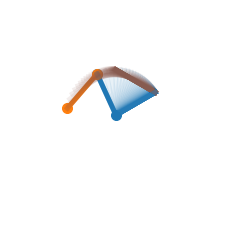

In [10]:
from scipy.optimize import fsolve
import math


# Apply iLQR to control end effector about some setpoint
x_0 = torch.tensor([2., 2., 0., 0.])
ee_goal = torch.tensor([0., 0.5])

# convert ee_goal to angles 
def func(x):
    return [ee_goal[0] - (length_m[0]*np.cos(x[0]) + length_m[1]*np.cos(x[0]+x[1])),
            ee_goal[1] - (length_m[0]*np.sin(x[0]) + length_m[1]*np.sin(x[0]+x[1]))] 

root = fsolve(func, [1, 1])
ee_goal = torch.tensor(root)
H = 100

dynamics_fun = lambda x, u: manipulator_dynamics(x, u)
cost_fun = lambda x, u: end_effector_cost(x, u, ee_goal)

# assume initial feasible trajectory is x_traj, u_traj
# to do this, we take an initial trajectory from LQR
A, B, Q, R = lqr_input_matrices(x_ref, u_ref, dynamics_fun, cost_fun)
K_list = lqr_gains(A, B, Q, R, H)

ee_goal_w_vel = torch.cat( (ee_goal, torch.zeros(2)), 0)
x_traj, u_traj = lqr_forward(x_0, ee_goal_w_vel, K_list, manipulator_dynamics)

# ran a simple test where initialized trajectories randomly; still successful reaches ee_goal
#x_traj = []
#u_traj = []
#for i in range(H):
#   x_traj.append(torch.tensor(np.random.rand(4)).float())
#   u_traj.append(torch.tensor(np.random.rand(2)).float())


# now iterate through iLQR

N = 8 # number of iLQR iterations

x_off = torch.zeros(H, len(x_0), 1) # hardcode x_off as 0 
# this can be done since we work in a delta space
# when testing x_off, it was near 0 (~1e-13) regardless

for _ in range(N):
    #compute time-varying LQR matrices
    if len(x_traj[0]) != 4:
        x_traj = [x[0:4] for x in x_traj]
    A_arr, B_arr, Q_arr, R_arr = time_varying_lqr_matrices(x_traj, u_traj, dynamics_fun, cost_fun)


    # obtain affine dynamics by augmenting into homogenous coordinates
    _, A_arr_aug, B_arr_aug, Q_arr_aug = affine_projection(x_traj, x_off, A_arr, B_arr, Q_arr, u_traj, cost_fun)

    K_list = time_varying_lqr_gains(A_arr_aug, B_arr_aug, Q_arr_aug, R_arr, H)
    
    x_traj, u_traj = time_varying_lqr_forward(x_0, x_traj, u_traj, K_list, dynamics_fun, A_arr_aug, B_arr_aug, ee_goal_w_vel)

x_opt_traj = x_traj
animate_arm(x_opt_traj, draw_trace=True)

(array([-0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

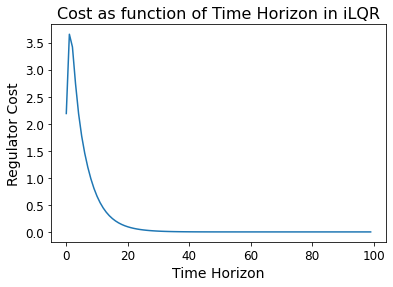

In [11]:
time_horizon = np.arange(len(x_traj))
u_traj = [u.detach() for u in u_traj]
cost_arr = []
for i in range(len(x_traj)):
    #print(x_traj[i])
    #print("u: ", u_traj[i])
    #print(ee_goal)
    cost_arr.append(regulator_cost(x_traj[i], u_traj[i], ee_goal).detach().numpy())
plt.plot(time_horizon, cost_arr)
plt.title('Cost as function of Time Horizon in iLQR', fontsize=16)  # Title
plt.xlabel('Time Horizon', fontsize=14)       # X-axis label
plt.ylabel('Regulator Cost', fontsize=14)       # Y-axis label
plt.xticks(fontsize=12)                 # X-axis tick labels
plt.yticks(fontsize=12)  

# Extra Credit: Choose Your Adventure!


For the extra credit problem, I apply iLQR on an $N=7$ link manipulator, rewriting the dynamics function and forward functions to work with the higher dimension input. First we rewrite certain LQR components of the code to work with the higher dimensional input.

If we want to assume that $x_{ref}$ instead represents the initial position $(x, y)$ (instead of the angles), we can just solve a nonlinear system of 7 equations via fsolve in the same way that it was done in iLQR. While these equations would be rather tedious to compute, we note that it would be feasible. It is worth noting that there may also be a number of potential angle configurations that would achieve such a final position.

In [12]:
# Parameters of the 7-link arm
# note that these parameters are identical to the N=2 link arm, just with 7 components
num_links = 7
length_m = 0.5 * np.ones(num_links)
mass_kg = 1 * np.ones(num_links) #  Assume that the mass of the link is concentrated at the end of the link.
base_se2 = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]) # Base of the arm in world frame

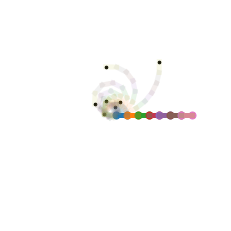

In [13]:
def animate_arm_7_link(x_traj, draw_ee=False, draw_trace=False):
    """ Animate the arm as it follows a joint angle trajectory
    Args:
        theta_traj: List of (N,1) joint angles
        draw_ee: If true, plot a trace of the end effector as it moves
    Returns:
        animate object
    """
    fig = plt.figure()
    plt.xlim([-5., 5.])
    plt.ylim([-5., 5.])
    plt.axis('off')
    plt.grid()
    plt.gca().set_aspect('equal', adjustable='box')

    arm_lines = []
    for idx in range(0, length_m.shape[0]):
        arm_lines += plt.plot([0, 0], [0, 0], '-o', linewidth=5, markersize=7)

    def update_arm(i):
        theta = x_traj[i][:7]
        link_pos = forward_kinematics(theta, length_m, base_se2)
        if draw_ee:
            plt.scatter(link_pos[-1,0], link_pos[-1,1], s=7, color='k')
        if draw_trace:
            colors = plt.cm.tab10(np.linspace(0,1,link_pos.shape[0]))
            for idx in range(1, link_pos.shape[0]):
                plt.plot(link_pos[idx-1:idx+1,0], link_pos[idx-1:idx+1,1], linewidth=5, alpha=0.1, color=colors[idx-1])
        for idx in range(1, link_pos.shape[0]):
            arm_lines[idx-1].set_data(link_pos[idx-1:idx+1,0], link_pos[idx-1:idx+1,1])

    anim = FuncAnimation(fig, update_arm, frames=len(x_traj), interval=30, blit=False, repeat=False)
    return anim

# Let's animate the arm moving from an initial to a final configuration
x_0 = np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
x_f = np.array([2., 2., 2., 2., 2., 2., 2., 0., 0., 0., 0., 0., 0., 0.])
theta_traj = list(np.linspace(x_0, x_f, num=10, endpoint=True))
animate_arm_7_link(theta_traj, draw_ee=True, draw_trace=True)

In [14]:
def manipulator_dynamics_7_link(x, u, dt=0.1):
    """ Compute the dynamics of a manipulator
    Args:
        x: (2N,1) array of arm state (joint angle, joint velocity)
        u: (N,1) array of joint torques
        dt: discrete time interval
    Returns:
        The next state
    Hint: Make sure this function mantains the gradient to the inputs
    """
    joint_angle, joint_vel = x[:7], x[7:]
    
    
    # get mass and length
    mass_list = torch.tensor(mass_kg)
    length_list = torch.tensor(length_m)
    

    # \tau_i = ml^2 \ddot{\theta}_i
    joint_accel = u / (mass_list * (length_list ** 2)) 

    
    next_x_angle = joint_angle + dt * joint_vel + dt ** 2 * joint_accel / 2 
    next_x_vel = joint_vel + dt * joint_accel
    
    next_x = torch.cat((next_x_angle, next_x_vel), 0)

    return next_x

def regulator_cost_7_link(x, u, theta_ref):
    """ Computes quadratic cost of state, action pair
    Args:
        x: Current state
        u: Current control action
        theta_ref: The reference angle to regulate the arm around
    Returns:
        Scalar cost
    """
    theta, theta_dot = x[:7], x[7:]
    delta_angle = torch.sum(torch.pow(theta - theta_ref, 2))
    delta_vel = torch.sum(torch.pow(theta_dot, 2))
    delta_u = torch.sum(torch.pow(u, 2))

    return delta_angle + delta_vel + delta_u

def lqr_gains_7_link(A, B, Q, R, H):
    """ Run value iteration and compute V and K matrices for each time step
    Args:
        A: (2N, 2N) dynamics matrix
        B: (2N, N) dynamics matrix
        Q: (2N, 2N) quadratic cost matrix
        R: (N, N) quadratic cost matrix
        H: Time horizon
    Returns:
        List of K matrices for each timestep
    """
    K_matrices = torch.empty(H, 7, 14)
    V_t = Q 
    K_matrices[H-1] = torch.zeros_like(B.T) # B.T has the correct shape of N x 2N
    for t in range(H-2, -1, -1):
        #print(torch.inverse(R + B.T @ V_t @ B))
        #print((R + B.T @ V_t @ B))
        K_prior = - (torch.linalg.inv(R + B.T @ V_t @ B)) @ B.T @ V_t @ A 
        K_matrices[t] = K_prior
        # this term is exploding
        #print((A + B @ K_prior).T @ V_t @ (A + B @ K_prior))
        
        
        V_t_prior = Q + (K_prior.T @ R @ K_prior) + ((A + B @ K_prior).T @ V_t @ (A + B @ K_prior))
        #print(V_t - V_t_prior)
        V_t = V_t_prior
    #print(K_matrices)
    return K_matrices


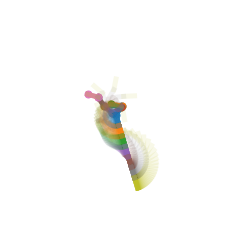

In [15]:
# Apply LQR to regulate the arm starting from an initial state
x_0 = torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 0., 0., 0., 0., 0., 0., 0.]) # Initial state
x_ref = torch.tensor([5., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True) # State that we are regulating around
#x_ref = torch.tensor([0.5, 0.5, 0., 0.], requires_grad=True) # State that we are regulating around
u_ref = torch.tensor([0., 0., 0., 0., 0., 0., 0.], requires_grad=True)
H = 100 # Horizon

dynamics_fun_7_link = lambda x, u: manipulator_dynamics_7_link(x, u)
cost_fun_7_link = lambda x, u: regulator_cost_7_link(x, u, x_ref[0:7])

A, B, Q, R = lqr_input_matrices(x_ref, u_ref, dynamics_fun_7_link, cost_fun_7_link)

K_list = lqr_gains_7_link(A, B, Q, R, H)

x_traj, u_traj = lqr_forward(x_0,x_ref,K_list, manipulator_dynamics_7_link)

x_traj = [x.detach() for x in x_traj]
animate_arm_7_link(x_traj, draw_trace=True)

We now implement the iLQR subcomponent of the $N=7$ link arm

In [16]:
# Code for n=7 iLQR

def end_effector_cost_7_link(x, u, ee_goal):
    """ Computes cost of state, action pair
    Args:
        x: Current state
        u: Current control action
        ee_goal: The goal
        theta_ref: The reference angle to regulate the arm around
    Returns:
        Scalar cost
    """
    theta, theta_dot = x[:7], x[7:]
    delta_angle = torch.sum(torch.pow(theta - ee_goal, 2))
    delta_vel = torch.sum(torch.pow(theta_dot, 2))
    delta_u = torch.sum(torch.pow(u, 2))

    return delta_angle + delta_vel + delta_u


def time_varying_lqr_gains_7_link(A_arr, B_arr, Q_arr, R_arr, H):
    """ Run value iteration and compute V and K matrices for each time step
    Args:
        A_arr: Array of (2N, 2N) dynamics matrices
        B_arr: Array of (2N, N) dynamics matrices
        Q_arr: Array of (2N, 2N) quadratic cost matrices
        R_arr: Array of (N, N) quadratic cost matrices
        H: Time horizon
    Returns:
        List of K matrices for each timestep
    """
    K_matrices = torch.empty(H, 7, 15)
    V_t = Q_arr[H-1]
    K_matrices[H-1] = torch.zeros_like(B_arr[H-1].T) # zeros of correct shape: N x 2N
    for t in range(H-2, -1, -1):
        
        # cast everything to double to fix type errors
        A_arr[t] = A_arr[t].double()
        B_arr[t] = B_arr[t].double()
        Q_arr[t] = Q_arr[t].double()
        R_arr[t] = R_arr[t].double()
        V_t = V_t.double()
        K_prior = - (torch.linalg.inv(R_arr[t] + B_arr[t].T @ V_t @ B_arr[t])) @ B_arr[t].T @ V_t @ A_arr[t]
        K_matrices[t] = K_prior
        
        V_t_prior = Q_arr[t] + (K_prior.T @ R_arr[t] @ K_prior) + ((A_arr[t] + B_arr[t] @ K_prior).T @ V_t @ (A_arr[t] + B_arr[t] @ K_prior))

        V_t = V_t_prior

    return K_matrices


def time_varying_lqr_forward_7_link(x_0, x_traj, u_traj, K_list, dynamics_fun, A_arr, B_arr, x_target):
    """  Start from initial state and iteratively apply K matrices and dynamics
    to roll out a trajectory
    Args:
        x_0: (2N+1, 1) initial state
        x_traj: nominal trajectory of states
        u_traj: nominal trajectory of actions
        K_list: list of K matrices for each time step
        A_arr: list of A matrices for each time step
        B_arr: list of B matrices for each time step
        x_target: nominal point
    Returns:
        List of states, actions one for each timestep
    """

    x_traj_update = []
    u_traj_update = []

    delta_x = torch.zeros_like(x_0)
    delta_u = K_list[0] @ torch.cat((delta_x, torch.ones(1)), 0)
    
    x_ref = delta_x + x_traj[0]
    u_ref = delta_u + u_traj[0]

    x_traj_update.append(x_ref)
    u_traj_update.append(u_ref)

    
    for i in range(1, len(K_list)):


        delta_x = delta_x.double()
        delta_u = delta_u.double()
        A_arr[i] = A_arr[i].double()
        B_arr[i] = B_arr[i].double()
        K_list[i] = K_list[i].double()
        
        delta_x = A_arr[i] @ torch.cat((delta_x, torch.ones(1)), 0) + B_arr[i] @ delta_u
        delta_x = delta_x[0:14]

        x_ref = delta_x + x_traj[i]
        temp = torch.cat((delta_x, torch.ones(1)), 0).double()
        delta_u = K_list[i].double() @ temp.double()
        u_ref = delta_u + u_traj[i]
        

        x_traj_update.append(x_ref)
        u_traj_update.append(u_ref)

    return x_traj_update, u_traj_update


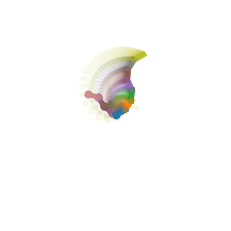

In [17]:
# Apply iLQR to control end effector about some setpoint
x_0 = torch.tensor([1., 2., 3., 4., 5., 6., 7., 0., 0., 0., 0., 0., 0., 0.])
ee_goal = torch.tensor([0.5, 0.5, 0.5, 0.5, -0.5, -0.5, -0.5])
H = 100

dynamics_fun_7_link = lambda x, u: manipulator_dynamics_7_link(x, u)
cost_fun_7_link = lambda x, u: end_effector_cost_7_link(x, u, ee_goal)

# assume initial feasible trajectory is x_traj, u_traj
# to do this, we take an initial trajectory from LQR
A, B, Q, R = lqr_input_matrices(x_ref, u_ref, dynamics_fun_7_link, cost_fun_7_link)
K_list = lqr_gains_7_link(A, B, Q, R, H)
ee_goal_w_vel = torch.cat((ee_goal, torch.zeros(7)), 0)
x_traj, u_traj = lqr_forward(x_0, ee_goal_w_vel, K_list, manipulator_dynamics_7_link)

# now iterate through iLQR

N = 5 # number of iLQR iterations
x_off = torch.zeros(H, len(x_0), 1) # hardcode x_off as 0 

for _ in range(N):
    # compute time-varying LQR matrices
    if len(x_traj[0]) != 14: # if augmented dimension, remove last value
        x_traj = [x[0:14] for x in x_traj]

    A_arr, B_arr, Q_arr, R_arr = time_varying_lqr_matrices(x_traj, u_traj, dynamics_fun_7_link, cost_fun_7_link)


    # obtain affine dynamics by augmenting into homogenous coordinates
    _, A_arr_aug, B_arr_aug, Q_arr_aug = affine_projection(x_traj, x_off, A_arr, B_arr, Q_arr, u_traj, cost_fun_7_link)

    

    K_list = time_varying_lqr_gains_7_link(A_arr_aug, B_arr_aug, Q_arr_aug, R_arr, H)


    # obtain new trajectories
    x_traj, u_traj = time_varying_lqr_forward_7_link(x_0, x_traj, u_traj, K_list, dynamics_fun, A_arr_aug, B_arr_aug, ee_goal_w_vel)


x_opt_traj = x_traj
animate_arm_7_link(x_opt_traj, draw_trace=True)